**Домашняя работа №3 по курсу аналитика данных, студент Щеглова Т.И.**

Вам нужно проанализировать биоинформатический датасет (ссылка на скачивание) по пространственной транскриптомике (дополнительная информация по теме) пациентов с плоскоклеточным раком. В нем клетки (колонка cell_type) объединены в микроокружения (колонка cell_interaction) в зависимости от взаимодействия этих клеток. Вашей основной задачей будет поиск отличий в организации микроокружения у пожилых и молодых пациентов (колонка age_group).

План работы:
    1. Провести разведывательный анализ данных и подготовить датасет для анализа (проверка на пропущенные данные, дубликаты).
    2. Создаем блок импортов.
    3. Выполнение заданий по пунктам.

In [28]:
# Блок import
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import combine_pvalues


In [2]:
# EDA Датасета
data = pd.read_csv("D://IDE/asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv")
data.head()
data.info()
missing_summ = data.isnull().sum()
missing_summ
dublicat = data.duplicated().sum()
dublicat

# при проверки на дубликаты и пропущенные значения их не оказалось, датасет подготовлен для анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


0

Задание 1: Есть ли стат-значимость между типом клетки и:

а) Размером клетки (area_of_cell), добавьте hue по возрастным группам.

Этапы решения:
1. Группируем данные по возрастным группам и типам клеток
2. Чтобы проверить наличие статистической значимости между типом клетки и размером клетки (area_of_cell), с учётом возрастной группы как дополнительного фактора (hue), можно использовать двухфакторный ANOVA тест, который позволяет оценить влияние двух независимых переменных на зависимую переменную. Проверим предпосылки для ANOVA: нормальность распределения размеров клеток внутри каждой группы и гомогенность дисперсий.
3. Оба критерия для проведения ANOVA теста не удовлетворяют этому тесту, поэтому проводим тест Краскела-Уоллиса, который не требует нормального распределения данных и гомогенности дисперсий.H0 - медианные значения размеров клеток одинаковы между группами. HA - медианные значения размеров клеток не одинаковы между группами.

Ответ по задаче - учитывая p value есть основания опровергнуть нулевую гипотезу.

In [3]:
# Предпосылка нормальности: тест Шапиро-Уилка на случайной подвыборке из каждой группы для улучшения производительности
# (тест Шапиро-Уилка имеет ограничения на размер выборки)
sample_groups = data.groupby(['cell_type', 'age_group']).apply(lambda x: x.sample(n=min(50, len(x)), random_state=1)).reset_index(drop=True)

shapiro_tests_corrected = sample_groups.groupby(['cell_type', 'age_group'])['area_of_cell'].apply(lambda x: stats.shapiro(x)[1])

# Предпосылка гомогенности дисперсий: тест Левена
levene_test_corrected = stats.levene(*[group['area_of_cell'].values for name, group in sample_groups.groupby(['cell_type', 'age_group'])])

shapiro_tests_corrected, levene_test_corrected


(cell_type      age_group  
 Blood cells    elder_group    2.646092e-03
                young_group    1.248048e-02
 Bone cells     elder_group    6.078316e-01
                young_group    5.989245e-04
 Immune type 1  elder_group    3.660160e-01
                young_group    1.418017e-04
 Immune type 2  elder_group    1.960572e-01
                young_group    1.142952e-03
 Largest cells  elder_group    5.097523e-11
                young_group    1.886881e-04
 Stroma cells   elder_group    1.869348e-03
                young_group    1.158378e-03
 Unclassified   elder_group    5.194888e-03
                young_group    1.431881e-04
 Vasculature    elder_group    7.530180e-04
                young_group    3.703051e-03
 Name: area_of_cell, dtype: float64,
 LeveneResult(statistic=40.35310873054497, pvalue=7.435914824245214e-87))

In [4]:
# Непараметрический тест Краскела-Уоллиса для оценки различий в размерах клеток между типами клеток и возрастными группами
kruskal_test = stats.kruskal(*[group['area_of_cell'].values for name, group in data.groupby(['cell_type', 'age_group'])])

kruskal_test


KruskalResult(statistic=8282.672977367456, pvalue=0.0)

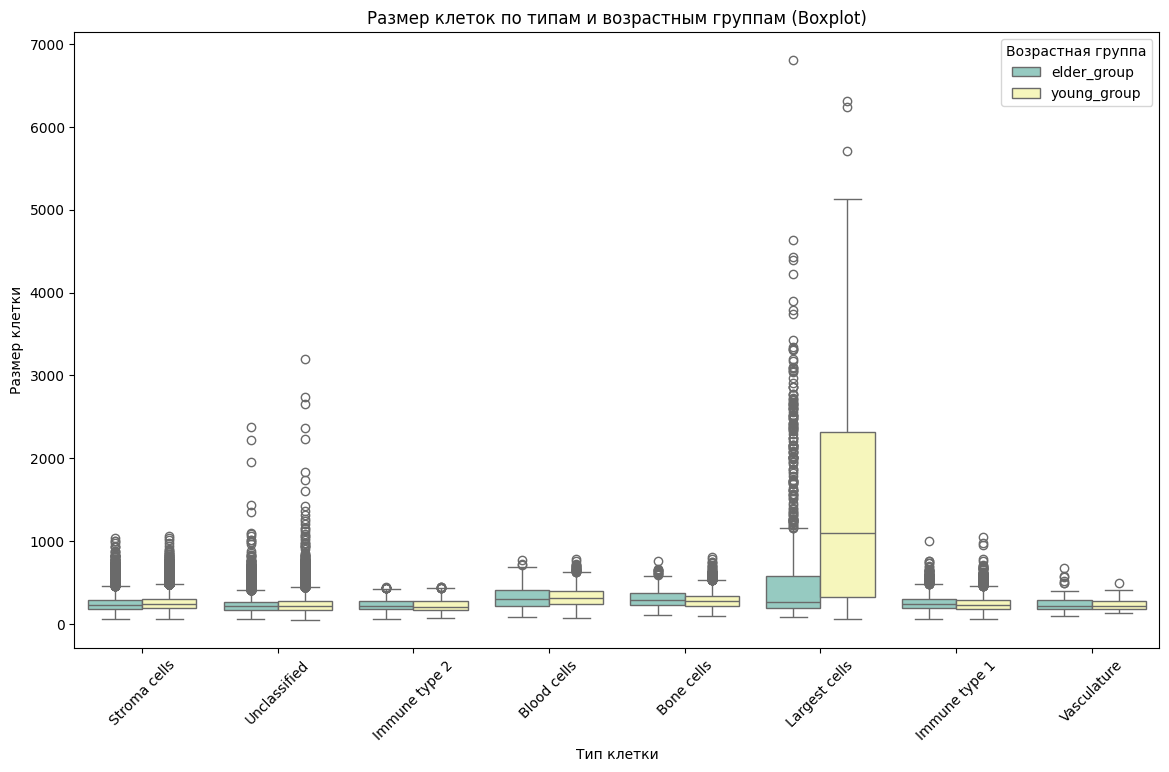

In [5]:
# Добавим визуализацию box_plot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

plt.figure(figsize=(14, 8))

# Boxplot 
sns.boxplot(x='cell_type', y='area_of_cell', data=data, hue='age_group', palette="Set3")

plt.title('Размер клеток по типам и возрастным группам (Boxplot)')
plt.xlabel('Тип клетки')
plt.ylabel('Размер клетки')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')

# Показать график
plt.show()




б) Есть ли стат-значимость между типом клетки и 'кспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

Этапы решения: 
1. Проверка на нормальность для immune_marker_1, immune_marker_2
2. Проверка на гомогенность дисперсии immune_marker_1, immune_marker_2
3. Учитывая нарушение предпосылок нормального распределения и гомогенности дисперсий для обоих иммунных маркеров, для анализа взаимосвязи между типом клетки, экспрессией иммунных маркеров и возрастными группами целесообразно использовать непараметрический подход. Применим тест Краскела-Уоллиса для каждого иммунного маркера отдельно, чтобы проверить наличие статистически значимых различий.
4. Визуализация данных.

Ответы к задаче - Результаты непараметрического теста Краскела-Уоллиса для обоих иммунных маркеров (immune_marker_1 и immune_marker_2) показывают статистически значимые различия в экспрессии этих маркеров между различными типами клеток и возрастными группами (p-значение = 0.0 для обоих тестов). Это означает, что можно отвергнуть нулевую гипотезу о том, что медианные значения экспрессии иммунных маркеров одинаковы между группами.

In [6]:
# Проверка на нормальность для immune_marker_1
shapiro_tests_imm1 = sample_groups.groupby(['cell_type', 'age_group'])['immune_marker_1'].apply(lambda x: stats.shapiro(x)[1])

# Проверка на гомогенность дисперсий для immune_marker_1
levene_test_imm1 = stats.levene(*[group['immune_marker_1'].values for name, group in data.groupby(['cell_type', 'age_group'])])

shapiro_tests_imm1, levene_test_imm1


(cell_type      age_group  
 Blood cells    elder_group    0.319520
                young_group    0.079748
 Bone cells     elder_group    0.010028
                young_group    0.309364
 Immune type 1  elder_group    0.317336
                young_group    0.229027
 Immune type 2  elder_group    0.438001
                young_group    0.016843
 Largest cells  elder_group    0.004562
                young_group    0.001921
 Stroma cells   elder_group    0.781307
                young_group    0.160721
 Unclassified   elder_group    0.375001
                young_group    0.274956
 Vasculature    elder_group    0.002512
                young_group    0.000067
 Name: immune_marker_1, dtype: float64,
 LeveneResult(statistic=385.60779812743345, pvalue=0.0))

In [7]:
# Проверка на нормальность для immune_marker_2
shapiro_tests_imm2 = sample_groups.groupby(['cell_type', 'age_group'])['immune_marker_2'].apply(lambda x: stats.shapiro(x)[1])

# Проверка на гомогенность дисперсий для immune_marker_2
levene_test_imm2 = stats.levene(*[group['immune_marker_2'].values for name, group in data.groupby(['cell_type', 'age_group'])])

shapiro_tests_imm2, levene_test_imm2


(cell_type      age_group  
 Blood cells    elder_group    9.569652e-06
                young_group    6.886804e-04
 Bone cells     elder_group    2.998062e-06
                young_group    6.151738e-03
 Immune type 1  elder_group    2.076995e-06
                young_group    1.375305e-02
 Immune type 2  elder_group    6.796605e-07
                young_group    3.059523e-08
 Largest cells  elder_group    1.488644e-06
                young_group    3.791008e-09
 Stroma cells   elder_group    1.066552e-06
                young_group    5.163073e-05
 Unclassified   elder_group    5.066189e-08
                young_group    1.428681e-04
 Vasculature    elder_group    1.279815e-03
                young_group    1.399207e-06
 Name: immune_marker_2, dtype: float64,
 LeveneResult(statistic=682.2786556597194, pvalue=0.0))

In [8]:
# Непараметрический тест Краскела-Уоллиса для immune_marker_1
kruskal_test_imm1 = stats.kruskal(*[group['immune_marker_1'].values for name, group in data.groupby(['cell_type', 'age_group'])])

# Непараметрический тест Краскела-Уоллиса для immune_marker_2
kruskal_test_imm2 = stats.kruskal(*[group['immune_marker_2'].values for name, group in data.groupby(['cell_type', 'age_group'])])

kruskal_test_imm1, kruskal_test_imm2


(KruskalResult(statistic=38298.896981927464, pvalue=0.0),
 KruskalResult(statistic=22413.384849525617, pvalue=0.0))

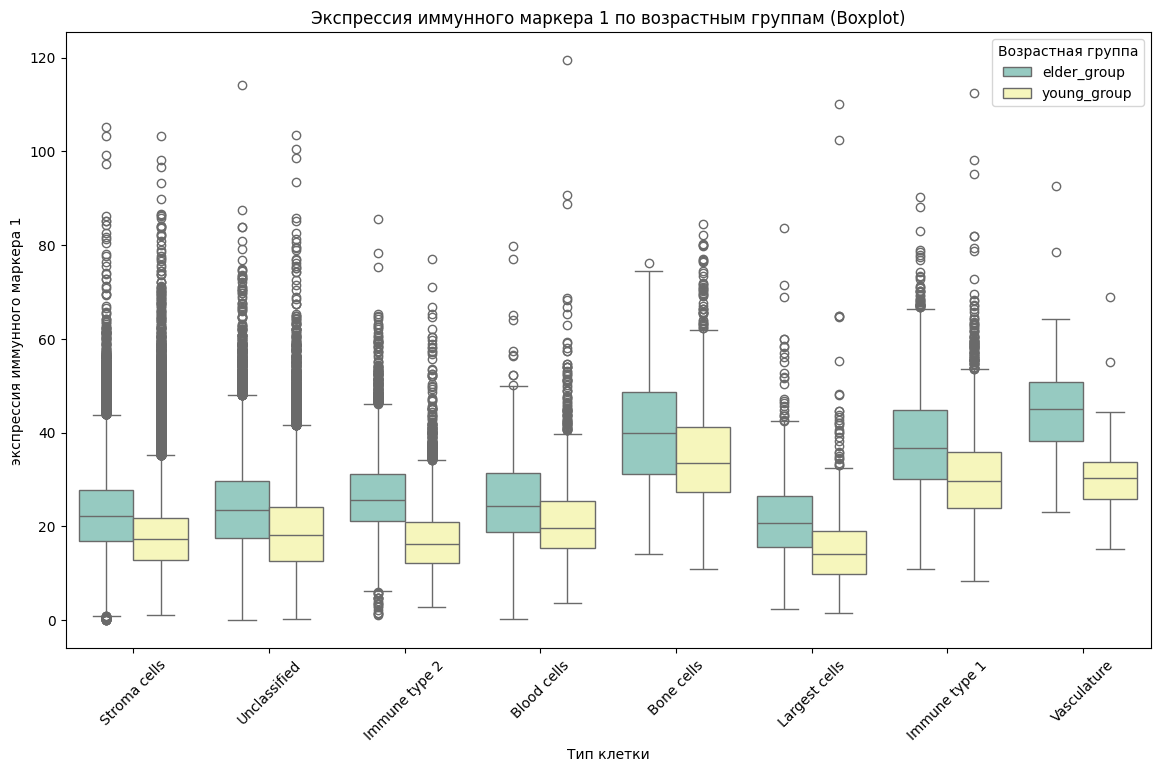

In [9]:
# Добавим визуализацию данных, box_plot, где по одной оси будет тип клеток, а по другой — оцениваемая статистика.

plt.figure(figsize=(14, 8))

# Boxplot 
sns.boxplot(x='cell_type', y='immune_marker_1', data=data, hue='age_group', palette="Set3")

plt.title('Экспрессия иммунного маркера 1 по возрастным группам (Boxplot)')
plt.xlabel('Тип клетки')
plt.ylabel('экспрессия иммунного маркера 1')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')

# Показать график
plt.show()



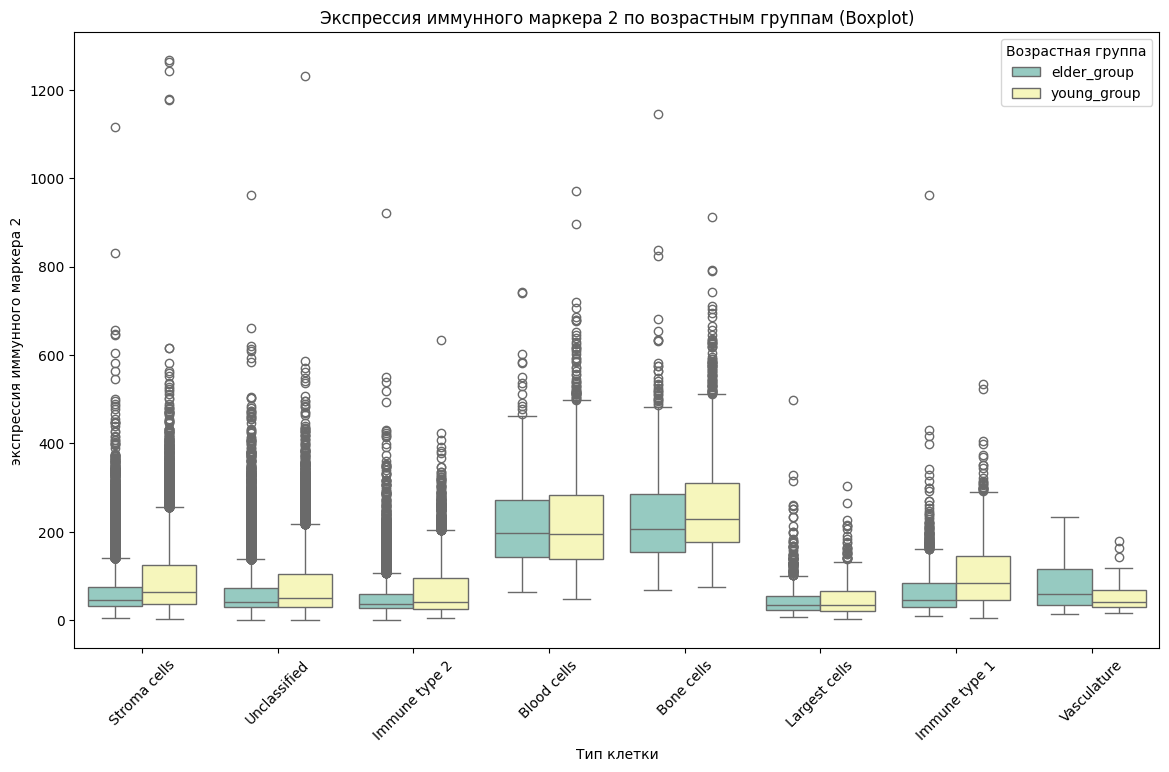

In [10]:
plt.figure(figsize=(14, 8))

# Boxplot 
sns.boxplot(x='cell_type', y='immune_marker_2', data=data, hue='age_group', palette="Set3")

plt.title('Экспрессия иммунного маркера 2 по возрастным группам (Boxplot)')
plt.xlabel('Тип клетки')
plt.ylabel('экспрессия иммунного маркера 2')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')

# Показать график
plt.show()

в) Есть ли стат-значимость между типом клетки и дистанцией до ближайших объектов (distance_to_vasculature, distance_to_largest_cell), добавьте hue по возрастным группам.

Этапы решения:
1. Проверка нормальности распределения для каждой группы с помощью теста Шапиро-Уилка.
2. Проверка гомогенности дисперсий с использованием теста Левена.
3. В зависимости от результатов этих тестов, использовать ANOVA (если данные соответствуют предпосылкам) или непараметрический тест (например, Краскела-Уоллиса), если данные не соответствуют предпосылкам нормального распределения или гомогенности дисперсий.
4. Визуализация данных.

Ответы к задаче - Результаты непараметрического теста Краскела-Уоллиса для distance_to_vasculature, distance_to_largest_cell показывают статистически значимые различия в экспрессии этих маркеров между различными типами клеток и возрастными группами (p-значение = 0.0 для обоих тестов). Это означает, что можно отвергнуть нулевую гипотезу о том, что медианные значения distance_to_vasculature, distance_to_largest_cell одинаковы между группами.

In [11]:
# Проверка на нормальность для distance_to_vasculature
shapiro_tests_dv = sample_groups.groupby(['cell_type', 'age_group'])['distance_to_vasculature'].apply(lambda x: stats.shapiro(x)[1])

# Проверка на гомогенность дисперсий для distance_to_vasculature
levene_test_dv = stats.levene(*[group['distance_to_vasculature'].values for name, group in data.groupby(['cell_type', 'age_group'])])

shapiro_tests_dv, levene_test_dv


(cell_type      age_group  
 Blood cells    elder_group    5.868683e-05
                young_group    6.749971e-02
 Bone cells     elder_group    9.844395e-05
                young_group    2.969293e-01
 Immune type 1  elder_group    9.375116e-05
                young_group    2.248822e-01
 Immune type 2  elder_group    4.333789e-03
                young_group    1.177621e-02
 Largest cells  elder_group    8.024072e-03
                young_group    5.566974e-03
 Stroma cells   elder_group    3.018661e-05
                young_group    3.227750e-01
 Unclassified   elder_group    1.528806e-02
                young_group    2.259622e-02
 Vasculature    elder_group    1.038534e-06
                young_group    2.630419e-11
 Name: distance_to_vasculature, dtype: float64,
 LeveneResult(statistic=591.9120410796023, pvalue=0.0))

In [12]:
# Проверка на нормальность для distance_to_largest_cell
shapiro_tests_lc = sample_groups.groupby(['cell_type', 'age_group'])['distance_to_largest_cell'].apply(lambda x: stats.shapiro(x)[1])

# Проверка на гомогенность дисперсий для immune_marker_1
levene_test_lc = stats.levene(*[group['distance_to_largest_cell'].values for name, group in data.groupby(['cell_type', 'age_group'])])

shapiro_tests_lc, levene_test_lc

(cell_type      age_group  
 Blood cells    elder_group    3.001183e-10
                young_group    5.549337e-04
 Bone cells     elder_group    2.809978e-05
                young_group    7.444267e-07
 Immune type 1  elder_group    1.551896e-02
                young_group    1.758003e-05
 Immune type 2  elder_group    8.309018e-07
                young_group    8.452182e-04
 Largest cells  elder_group    5.135843e-02
                young_group    7.582045e-03
 Stroma cells   elder_group    1.654297e-04
                young_group    8.665612e-03
 Unclassified   elder_group    6.020520e-06
                young_group    2.181131e-03
 Vasculature    elder_group    5.071295e-07
                young_group    7.390067e-08
 Name: distance_to_largest_cell, dtype: float64,
 LeveneResult(statistic=137.0157808821861, pvalue=0.0))

In [13]:
# Непараметрический тест Краскела-Уоллиса для distance_to_vasculature
kruskal_test_dv = stats.kruskal(*[group['distance_to_vasculature'].values for name, group in data.groupby(['cell_type', 'age_group'])])

# Непараметрический тест Краскела-Уоллиса для distance_to_largest_cell
kruskal_test_lc = stats.kruskal(*[group['distance_to_largest_cell'].values for name, group in data.groupby(['cell_type', 'age_group'])])

kruskal_test_dv, kruskal_test_lc

# Есть основаниия опровергнуть нулевую гипотезу

(KruskalResult(statistic=26108.31647981447, pvalue=0.0),
 KruskalResult(statistic=8640.707281637471, pvalue=0.0))

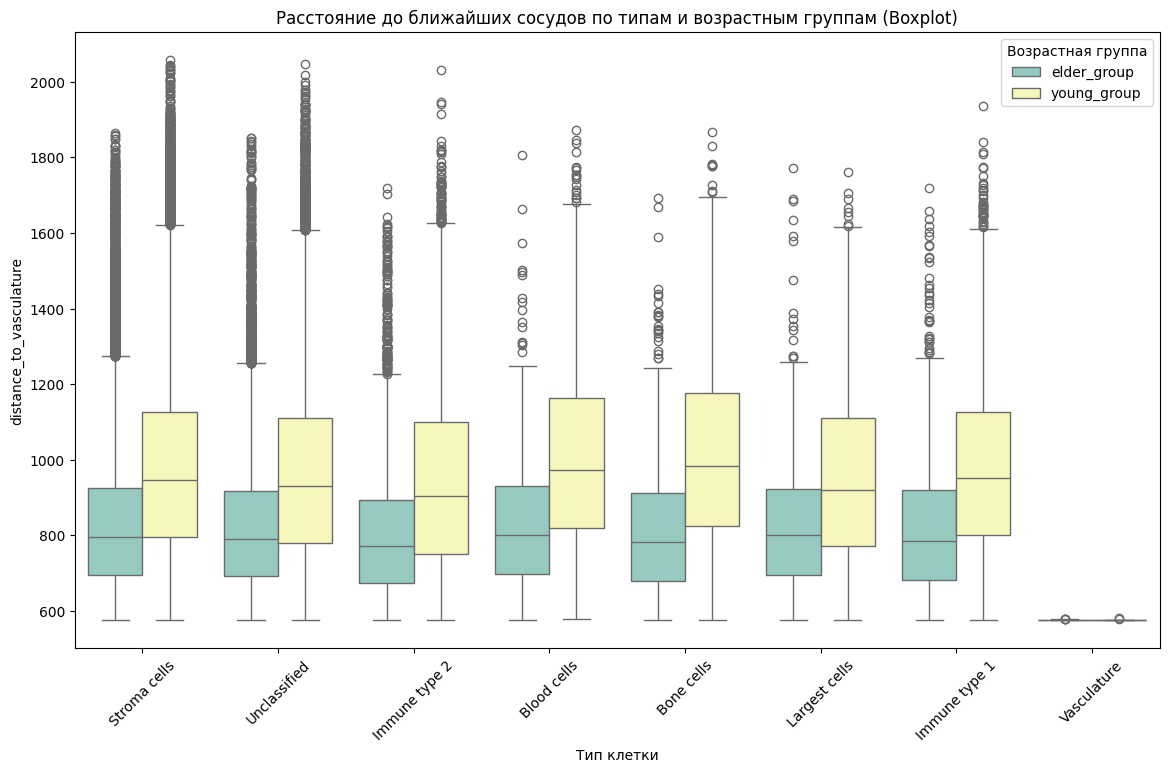

In [14]:
plt.figure(figsize=(14, 8))

# Boxplot 
sns.boxplot(x='cell_type', y='distance_to_vasculature', data=data, hue='age_group', palette="Set3")

plt.title('Расстояние до ближайших сосудов по типам и возрастным группам (Boxplot)')
plt.xlabel('Тип клетки')
plt.ylabel('distance_to_vasculature')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')

# Показать график
plt.show()

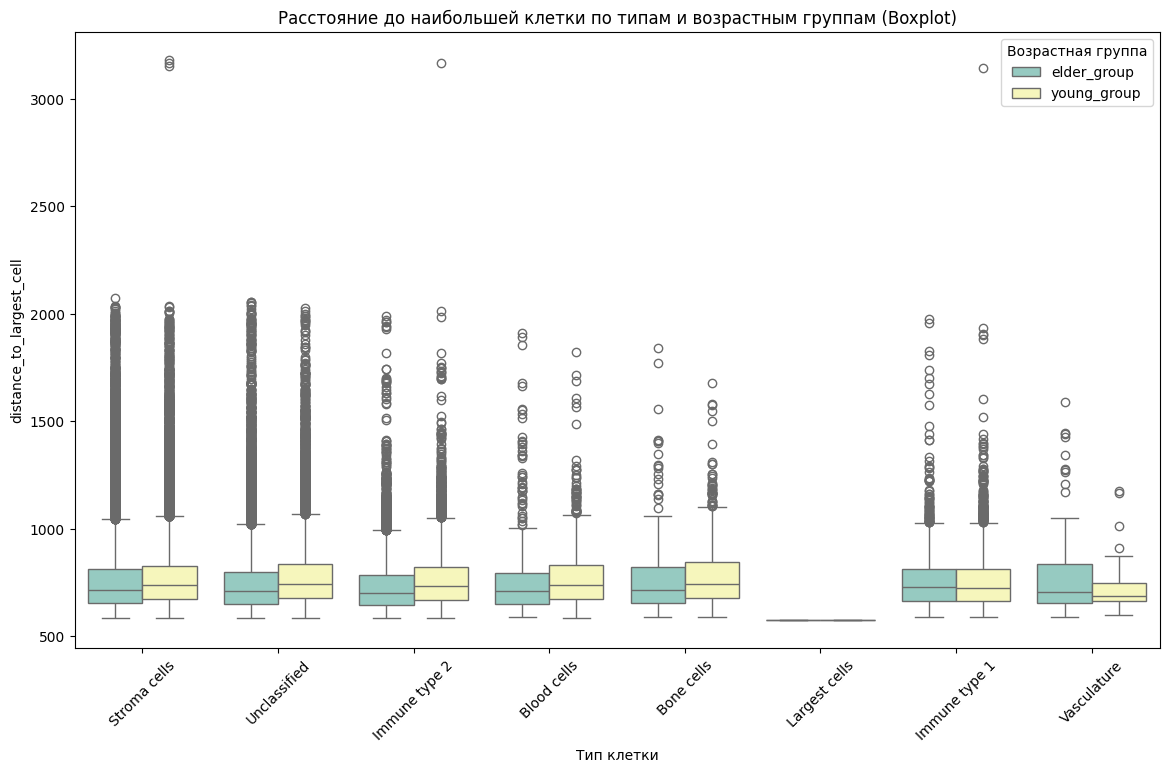

In [15]:
plt.figure(figsize=(14, 8))

# Boxplot 
sns.boxplot(x='cell_type', y='distance_to_largest_cell', data=data, hue='age_group', palette="Set3")

plt.title('Расстояние до наибольшей клетки по типам и возрастным группам (Boxplot)')
plt.xlabel('Тип клетки')
plt.ylabel('distance_to_largest_cell')
plt.xticks(rotation=45)
plt.legend(title='Возрастная группа')

# Показать график
plt.show()

Задача 2: В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

по Ох будут типы клеток,
по Оу — их количество.
Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

Этапы решения:
1. Сгруппировать данные по столбцам 'case_id', 'cell_type', 'cell_interaction'.
2. Визуализировать данные, учитывая, что визуализация предыдущего задания была в boxplot ршени этой задачи делала в swarmplot для наработки практики.
3. Выводы по задаче - по каждому типу клеток визуально видно распространение cell_interaction (для blood cells - community_4, bone cells - community_4 and community_1 and so on)

c:\Users\Taya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 70.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Taya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 67.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Taya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Taya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

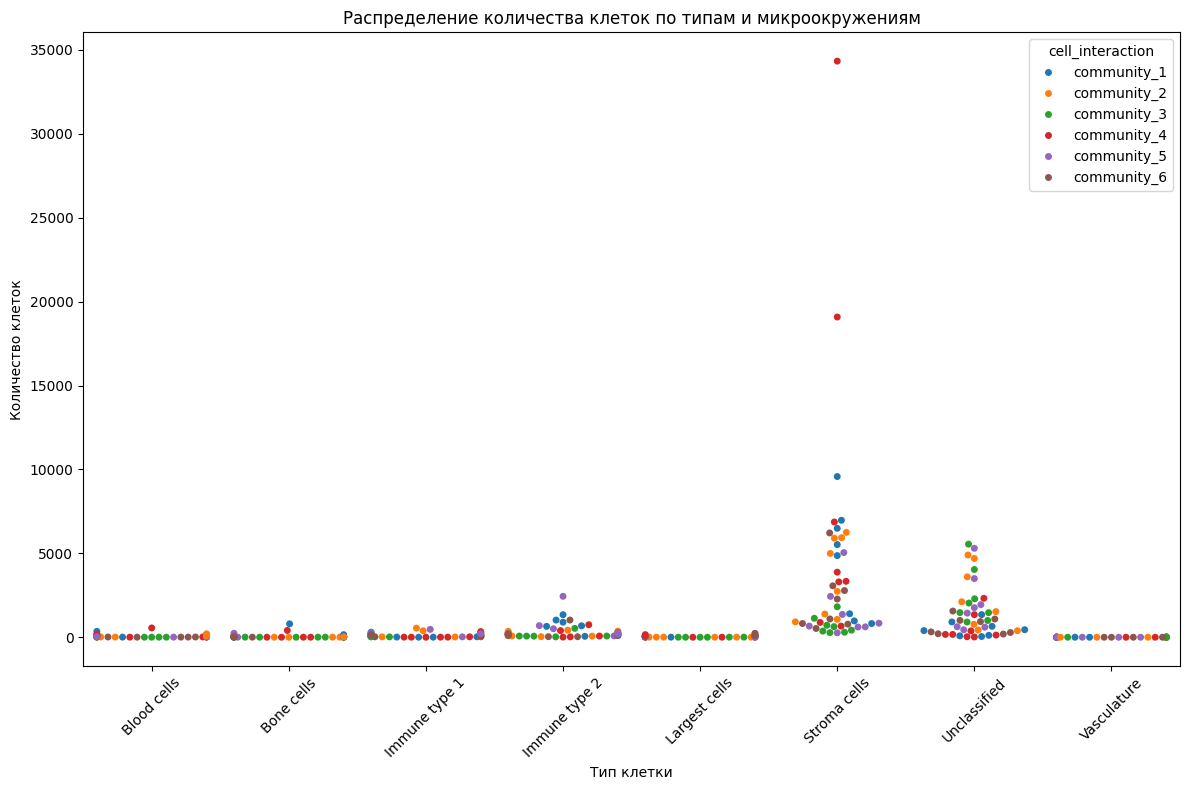

In [16]:
# Подсчет количества каждого типа клеток для каждого пациента в разных микроокружениях
cell_counts = data.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='count')

# Визуализация данных с использованием swarmplot, поскольку он наглядно показывает распределение количества клеток
plt.figure(figsize=(12, 8))
sns.swarmplot(data=cell_counts, x='cell_type', y='count', hue='cell_interaction')
plt.xticks(rotation=45)
plt.title('Распределение количества клеток по типам и микроокружениям')
plt.xlabel('Тип клетки')
plt.ylabel('Количество клеток')
plt.tight_layout()

plt.show()


Задача 3.  Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

по Ох будут микроокружения,
по Оу — их доля в ткани пациента.
Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

Этапы ршения: 1. Посчитать долю cell_interaction для каждого пациента.
2. Визуализация результатов с помощью box_plot

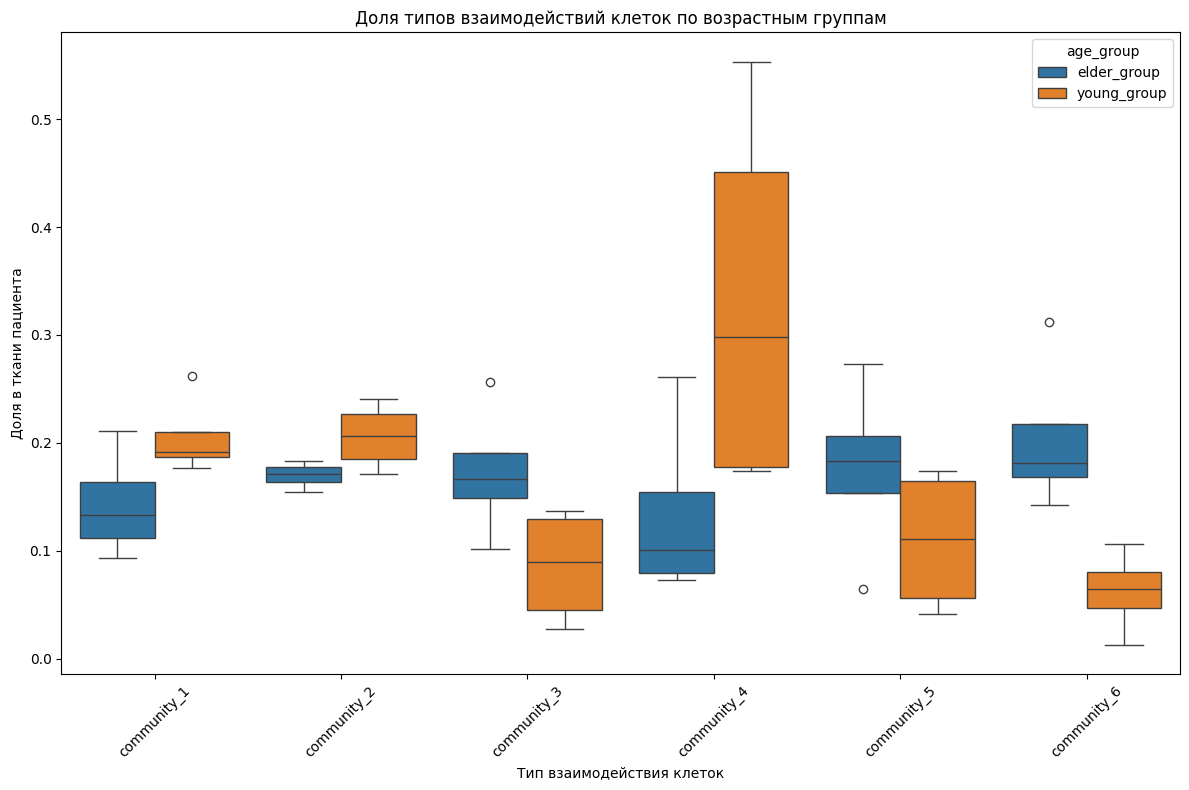

In [17]:
# Подсчет количества каждого типа взаимодействия клеток по каждому пациенту
interaction_counts = data.groupby(['case_id', 'age_group', 'cell_interaction']).size().reset_index(name='counts')

# Подсчет общего количества клеток по каждому случаю
total_counts = data.groupby(['case_id', 'age_group']).size().reset_index(name='total_counts')

# Объединение данных для расчета доли
df = pd.merge(interaction_counts, total_counts, on=['case_id', 'age_group'])

# Расчет доли каждого типа взаимодействия клеток
df['proportion'] = df['counts'] / df['total_counts']

# Визуализация данных
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_interaction', y='proportion', hue='age_group', data=df)
plt.title('Доля типов взаимодействий клеток по возрастным группам')
plt.ylabel('Доля в ткани пациента')
plt.xlabel('Тип взаимодействия клеток')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Задача 4. Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

Этапы решения. 1. Формирование выборок.
2. Формирование фугкции бутстрапа, ограничим выборку до 1000, чтоб уменьшить рассчеты.
3. Проведем анализ по группам.
Ответ на задачу - в среднем иммунные клетки располагаются ближе к сосудам и крупным клеткам, чем стромальные клетки, как в молодой, так и в пожилой возрастной группе, противореча предполагаемой гипотезе о том, что этот эффект наблюдается только у молодых пациентов.

In [23]:
# Определение необходимых данных
young_immune = data[(data['cell_type'].str.contains('Immune')) & (data['age_group'] == 'young_group')]
young_stroma = data[(data['cell_type'] == 'Stroma cells') & (data['age_group'] == 'young_group')]

elder_immune = data[(data['cell_type'].str.contains('Immune')) & (data['age_group'] == 'elder_group')]
elder_stroma = data[(data['cell_type'] == 'Stroma cells') & (data['age_group'] == 'elder_group')]

# Функции бутстрапа
def bootstrap_diff_means(data1, data2, n_iterations=1000):
    size = max(len(data1), len(data2))
    diff_means = []
    for _ in range(n_iterations):
        sample1 = np.random.choice(data1, size=size, replace=True)
        sample2 = np.random.choice(data2, size=size, replace=True)
        diff_means.append(np.mean(sample1) - np.mean(sample2))
    return np.mean(diff_means), np.std(diff_means)

# Проведение бутстрап анализа
bootstrap_young_vasculature = bootstrap_diff_means(young_immune['distance_to_vasculature'], young_stroma['distance_to_vasculature'])
bootstrap_young_largest_cell = bootstrap_diff_means(young_immune['distance_to_largest_cell'], young_stroma['distance_to_largest_cell'])

bootstrap_elder_vasculature = bootstrap_diff_means(elder_immune['distance_to_vasculature'], elder_stroma['distance_to_vasculature'])
bootstrap_elder_largest_cell = bootstrap_diff_means(elder_immune['distance_to_largest_cell'], elder_stroma['distance_to_largest_cell'])

bootstrap_young_vasculature, bootstrap_young_largest_cell, bootstrap_elder_vasculature, bootstrap_elder_largest_cell



((-24.555662070924523, 0.9443477462427621),
 (-6.942712459243081, 0.5234148724184975),
 (-27.580256081343023, 1.1614485897427151),
 (-19.79111310946184, 1.0536750213437043))

Задача 5. Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью метода scipy.stats.combine_pvalues(pvalues, method='fisher', weights=None)

Этапы решения: 1. Создадим функцию для пермутоционного теста
2. Проведем его отдельно для пожилых и молодых пациентов.
3. Интерпретируем результат.

Ответ на задачу - учитывая p-value выше 0.05 - оснований опровергнуть нулевую гипотезу нет, то есть вероятности нахождения иммуных клеток ближе к сосудам в группах пожилых и молодых пациентов равны.

In [30]:
# Функция пермутационного теста
def permutation_test(data_group, full_data, n_permutations=10000):
    observed_means = data_group.groupby('case_id')['distance_to_vasculature'].mean()
    n = len(observed_means)
    observed_mean_diff = observed_means.mean()
    perm_diffs = []

    for _ in range(n_permutations):
        # Выборка случайных значений из полной колонки с расстояниями
        perm_sample = np.random.choice(full_data, size=n, replace=True)
        # Расчет среднего по пермутированной выборке
        perm_mean = np.mean(perm_sample)
        # Разница между средними значениями
        perm_diff = perm_mean - observed_mean_diff
        perm_diffs.append(perm_diff)

    # Расчет p-value
    p_value = np.mean([diff < 0 for diff in perm_diffs])
    return p_value

# Выполнение пермутационного теста для молодых и пожилых пациентов
p_value_young = permutation_test(young_immune, data['distance_to_vasculature'])
p_value_elder = permutation_test(elder_immune, data['distance_to_vasculature'])

# Комбинирование p-значений для молодых и пожилых пациентов
combined_p_value = combine_pvalues([p_value_young, p_value_elder], method='fisher')

p_value_young, p_value_elder, combined_p_value


(0.5368,
 0.1485,
 SignificanceResult(statistic=5.058600028128096, pvalue=0.28133744476111266))